In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [39]:
def compute_diffusion_map(L, alpha=0.5, n_components=None, diffusion_time=0):
    """Compute the diffusion maps of a symmetric similarity matrix

        L : matrix N x N
           L is symmetric and L(x, y) >= 0

        alpha: float [0, 1]
            Setting alpha=1 and the diffusion operator approximates the
            Laplace-Beltrami operator. We then recover the Riemannian geometry
            of the data set regardless of the distribution of the points. To
            describe the long-term behavior of the point distribution of a
            system of stochastic differential equations, we can use alpha=0.5
            and the resulting Markov chain approximates the Fokker-Planck
            diffusion. With alpha=0, it reduces to the classical graph Laplacian
            normalization.

        n_components: int
            The number of diffusion map components to return. Due to the
            spectrum decay of the eigenvalues, only a few terms are necessary to
            achieve a given relative accuracy in the sum M^t.

        diffusion_time: float >= 0
            use the diffusion_time (t) step transition matrix M^t

            t not only serves as a time parameter, but also has the dual role of
            scale parameter. One of the main ideas of diffusion framework is
            that running the chain forward in time (taking larger and larger
            powers of M) reveals the geometric structure of X at larger and
            larger scales (the diffusion process).

            t = 0 empirically provides a reasonable balance from a clustering
            perspective. Specifically, the notion of a cluster in the data set
            is quantified as a region in which the probability of escaping this
            region is low (within a certain time t).

        References
        ----------

        [1] https://en.wikipedia.org/wiki/Diffusion_map
        [2] Coifman, R.R.; S. Lafon. (2006). "Diffusion maps". Applied and
        Computational Harmonic Analysis 21: 5-30. doi:10.1016/j.acha.2006.04.006
    """

    import numpy as np
    import scipy.sparse as sps

    from sklearn.manifold.spectral_embedding_ import _graph_is_connected

    if not sps.issparse(L):
        L = sps.csr_matrix(L)

    if not _graph_is_connected(L):
        raise ValueError('Graph is disconnected')

    ndim = L.shape[0]
    L_alpha = L.copy()
    if alpha > 0:
        # Step 2
        d = np.array(L_alpha.sum(axis=1)).flatten()
        d_alpha = np.power(d, -alpha)
        L_alpha.data *= d_alpha[L_alpha.indices]
        L_alpha = sps.csr_matrix(L_alpha.transpose().toarray())
        L_alpha.data *= d_alpha[L_alpha.indices]
        L_alpha = sps.csr_matrix(L_alpha.transpose().toarray())

        # Step 3
        d_alpha = np.power(np.array(L_alpha.sum(axis=1)).flatten(), -1)
        L_alpha.data *= d_alpha[L_alpha.indices]
    M = L_alpha

    from sklearn.utils.arpack import eigsh, eigs

    # Step 4
    func = eigs
    if n_components is not None:
        lambdas, vectors = func(M, k=n_components + 1)
    else:
        lambdas, vectors = func(M, k=max(2, int(np.sqrt(ndim))))
    del M

    if func == eigsh:
        lambdas = lambdas[::-1]
        vectors = vectors[:, ::-1]
    else:
        lambdas = np.real(lambdas)
        vectors = np.real(vectors)
        lambda_idx = np.argsort(lambdas)[::-1]
        lambdas = lambdas[lambda_idx]
        vectors = vectors[:, lambda_idx]
    
    # Step 5
    psi = vectors/vectors[:, [0]]
    if diffusion_time == 0:
        lambdas = lambdas[1:] / (1 - lambdas[1:])
    else:
        lambdas = lambdas[1:] ** float(diffusion_time)
    lambda_ratio = lambdas/lambdas[0]
    threshold = max(0.05, lambda_ratio[-1])

    n_components_auto = np.amax(np.nonzero(lambda_ratio > threshold)[0])
    n_components_auto = min(n_components_auto, ndim)
    if n_components is None:
        n_components = n_components_auto
    embedding = psi[:, 1:(n_components + 1)] * lambdas[:n_components][None, :]

    result = dict(lambdas=lambdas, vectors=vectors,
                  n_components=n_components, diffusion_time=diffusion_time,
                  n_components_auto=n_components_auto)
    return embedding, result

In [13]:
def compute_affinity(X, method='markov', eps=None):
    import numpy as np
    from sklearn.metrics import pairwise_distances
    D = pairwise_distances(X, metric='euclidean')
    if eps is None:
        k = int(max(2, np.round(D.shape[0] * 0.01)))
        eps = 2 * np.median(np.sort(D, axis=0)[k+1, :])**2
    if method == 'markov':
        affinity_matrix = np.exp(-(D * D) / eps)
    elif method == 'cauchy':
        affinity_matrix = 1./(D * D + eps)
    return affinity_matrix

In [8]:
import numpy as np
from sklearn.manifold import SpectralEmbedding, TSNE
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import rbf_kernel

In [61]:
def compare_methods(X, title):
    '''
    D = pairwise_distances(X)
    k = max(2, D.shape[0] * 0.01)
    eps = 2 * np.median(np.sort(D, axis=0)[k+1, :])**2
    K = np.exp(-(D**2)/eps)
    '''
    fig = plt.figure()
    plt.figure(figsize=(15, 5))
    L = compute_affinity(X.copy(), method='markov')
    for idx, t in enumerate([0, 0.1, 1, 10, 100, 1000, 10000]):
        de, _ = compute_diffusion_map(L, alpha=0.5, diffusion_time=t, n_components=10)
        ed = (de - de[0, :])
        ed = np.sqrt(np.sum(ed * ed , axis=1))
        ed = ed/max(ed)
        plt.subplot(2, 7, idx + 1)
        plt.scatter(X[:, 0], X[:, 1], c=ed, cmap=plt.cm.Spectral, linewidths=0)
        plt.axis('tight')
        plt.colorbar()
        plt.title('t={:g}'.format(t))
    for idx, c in enumerate([2, 3, 4, 5, 10, 20, 50]):
        se = SpectralEmbedding(n_components=c).fit_transform(X.copy())
        ed = (se - se[0, :])
        ed = np.sqrt(np.sum(ed * ed , axis=1))
        ed = ed/max(ed)
        plt.subplot(2, 7, 7 * (2 - 1) + idx + 1)
        plt.scatter(X[:, 0], X[:, 1], c=ed, cmap=plt.cm.Spectral, linewidths=0)
        plt.axis('tight')
        plt.colorbar()
        plt.title('num_c=%d' % (c))
    ph = plt.suptitle(title)

In [62]:
n=2000
t=np.power(np.sort(np.random.rand(n)), .7)*10
al=.15;bet=.5;
x1=bet * np.exp(al * t) * np.cos(t) + 0.1 * np.random.randn(n)
y1=bet * np.exp(al * t) * np.sin(t) + 0.1 * np.random.randn(n)
X = np.hstack((x1[:, None], y1[:, None]))

### Plot original data with the t parameter corresponding to color

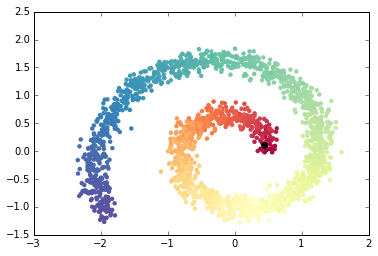

In [63]:
plt.scatter(x1, y1, c=t, cmap=plt.cm.Spectral, linewidths=0)
ph = plt.plot(x1[0], y1[0], 'ko')

### Compare diffusion embedding to spectral embedding (row 2)

In the case of diffusion embedding the diffusion time is being modified, while the number of components are being modified for spectral embedding. In the case of spectral embedding we are either using the default affinity (row 2).

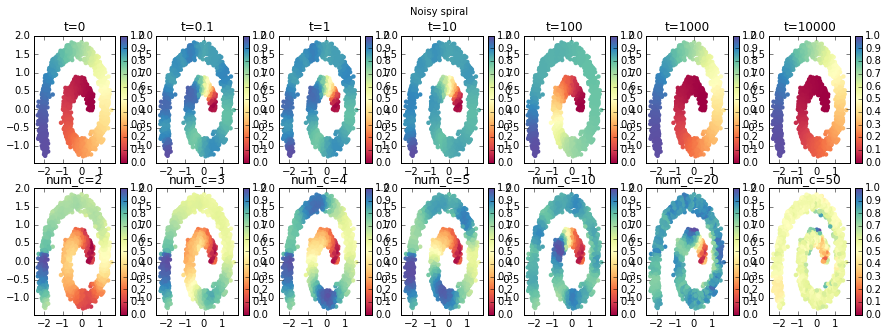

In [64]:
compare_methods(X, 'Noisy spiral')

In [65]:
def make_circles(n_samples=100, shuffle=True, noise=None, random_state=None,
                 factors=[.8, 1.5, 2]):
    """Make a large circle containing a smaller circle in 2d.

    A simple toy dataset to visualize clustering and classification
    algorithms.

    Parameters
    ----------
    n_samples : int, optional (default=100)
        The total number of points generated.

    shuffle: bool, optional (default=True)
        Whether to shuffle the samples.

    noise : double or None (default=None)
        Standard deviation of Gaussian noise added to the data.

    factor : double < 1 (default=.8)
        Scale factor between inner and outer circle.

    Returns
    -------
    X : array of shape [n_samples, 2]
        The generated samples.

    y : array of shape [n_samples]
        The integer labels (0 or 1) for class membership of each sample.
    """

    # so as not to have the first point = last point, we add one and then
    # remove it.
    linspace = np.linspace(0, 2 * np.pi, n_samples + 1)[:-1]
    base_circ_x = np.cos(linspace)
    base_circ_y = np.sin(linspace)
    factor = factors[0]
    X = np.hstack(((factor * base_circ_x)[:, None], (factor * base_circ_y)[:, None]))
    y = np.zeros(n_samples)
    for idx, factor in enumerate(factors[1:]):
        inner_circ_x = base_circ_x * factor
        inner_circ_y = base_circ_y * factor
        X = np.vstack((X, np.hstack(((factor * base_circ_x)[:, None], (factor * base_circ_y)[:, None]))))
        y = np.hstack([y, (idx + 1) * np.ones(n_samples)])

    if not noise is None:
        X += np.random.normal(scale=noise, size=X.shape)

    return X, y

### Plot the noisy circles

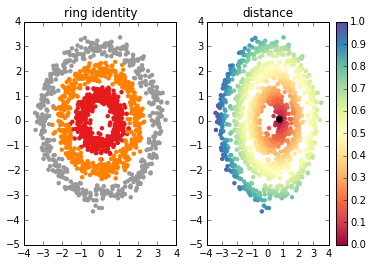

In [66]:
n_samples = 500
X, y = make_circles(n_samples=n_samples, factors=[1, 2, 3], noise=.2)
ed = (X - X[0, :])
ed = np.sqrt(np.sum(ed * ed , axis=1))
ed = ed/max(ed)

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, linewidths=0)
plt.title('ring identity')
plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], c=ed, cmap=plt.cm.Spectral, linewidths=0)
plt.title('distance')
plt.colorbar()
ph = plt.plot(X[0, 0], X[0, 1], 'ko')

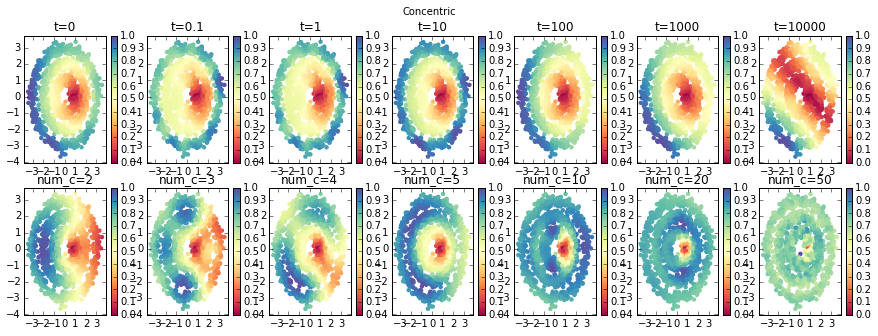

In [67]:
compare_methods(X, 'Concentric')